Description: This script analyzes patch sizes by class

Author: David Gormley

Last Modified: 5/5/25

Structure

1) Import Dependencies and Mount Drive

2) Create dataframe for Analysis

3) How different are width and heights?

4) Grouping by class and evaluating width differences

5) Exploring image size differences between cases

**1) Import Dependencies and Mount Drive**

In [ ]:
import os
import glob
import re
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor, as_completed


from google.colab import drive

In [ ]:

# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


**2) Create dataframe for Analysis**

In [ ]:
# ─── LOAD LABELS & BUILD CLASS MAP ───────────────────────────────────────
labels_df = pd.read_csv(
    "/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)

class_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}

# ─── GET ALL IMAGE PATHS (unchanged) ────────────────────────────────────
def get_case_paths(folder, case_list, stains=None):
    case_set = set(case_list)
    if stains is None:
        stains = ['h&e']
    stains = [s.lower() for s in stains]

    out = []
    with os.scandir(folder) as it:
        for entry in it:
            if not entry.is_file():
                continue
            name = entry.name.lower()
            if not any(st in name for st in stains):
                continue
            m = re.search(r"case_(\d+)_", entry.name, flags=re.IGNORECASE)
            if m and int(m.group(1)) in case_set:
                out.append(entry.path)
    return out

image_folder = "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr16"
train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
test_cases   = [77,60,79,70,90,92,25,12]

all_paths = get_case_paths(image_folder, train_cases + test_cases)

# ─── PARALLEL SIZE-READING ──────────────────────────────────────────────
def process_path(p):
    # open only header
    with Image.open(p) as img:
        w, h = img.size
    basename = os.path.basename(p)
    cid = int(
        re.search(r"case_(\d+)_", basename, flags=re.IGNORECASE)
        .group(1)
    )
    return {
        'case_number': cid,
        'width': w,
        'height': h,
        'label': class_map[cid]
    }

records = []
with ThreadPoolExecutor(max_workers=8) as exe:
    futures = {exe.submit(process_path, p): p for p in all_paths}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Reading sizes"):
        records.append(fut.result())

# Build DataFrame including new case_number column
df = pd.DataFrame(records)
print(df.shape)
print(df.head())



Reading sizes: 100%|██████████| 1527/1527 [01:11<00:00, 21.43it/s]

(1527, 4)
   case_number  width  height  label
0           77    271     272      0
1           77    148     148      0
2           77    176     175      0
3           77    176     177      0
4           77    164     163      0


**3) How different are widths and heights?**
- Answer: Not very!

In [ ]:
pd.DataFrame(np.abs(df["width"]-df["height"])).value_counts()

,count
0,
0,883
1,615
2,29


**4) Grouping by class and evaluating width differences**
- The different classes have meaningfully different images sizes!

In [ ]:
df.groupby("label")["width"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,906.0,183.559603,113.850388,6.0,111.0,160.0,223.75,951.0
1,621.0,146.798712,117.860660,13.0,68.0,120.0,200.00,888.0


<Axes: >

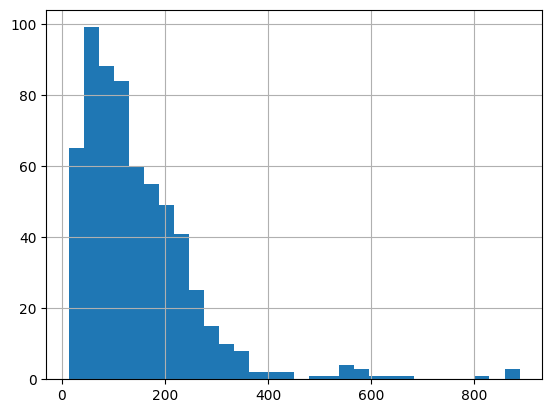

In [ ]:
df[df.label == 1]["width"].hist(bins=30)

<Axes: >

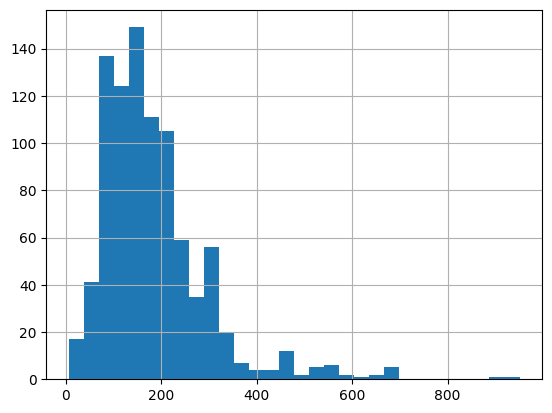

In [ ]:
df[df.label == 0]["width"].hist(bins=30)

**5) Exploring image size differences between cases**
- Both mean and std vary substantially between cases

In [ ]:
df.groupby("case_number")[["width", "label"]].describe()

width                                                        \
             count        mean         std    min     25%    50%     75%   
case_number                                                                
1             49.0  313.102041  134.248719  151.0  227.00  261.0  357.00   
2            106.0  175.820755   84.785870   54.0  129.75  162.0  203.75   
3            101.0  220.970297   64.480300  127.0  195.00  204.0  239.00   
9             54.0  213.518519  190.224469   47.0   76.00  169.5  279.75   
12           102.0   44.313725   29.464185   13.0   23.00   37.0   59.00   
34             2.0  929.000000   31.112698  907.0  918.00  929.0  940.00   
77            83.0  203.903614   82.312850   52.0  167.50  204.0  249.50   
78           128.0  138.796875   67.261665   71.0   83.00  114.0  175.25   
79           384.0  161.942708   92.620858    6.0  100.00  151.0  208.75   
85           101.0  233.960396   94.495812   32.0  159.00  220.0  315.00   
89           154.0  117.584416   99.581654   46.0   75.00   83.0  123.00   
90           102.0  248.078431  183.392491   71.0  112.00  171.0  337.75   
92           161.0  120.149068   46.138407   28.0  100.00  123.0  147.00   

                    label                                     
               max  count mean  std  min  25%  50%  75%  max  
case_number                                                   
1            655.0   49.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
2            561.0  106.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3            576.0  101.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
9            872.0   54.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
12           163.0  102.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
34           951.0    2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
77           467.0   83.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
78           459.0  128.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
79           695.0  384.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
85           504.0  101.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
89           888.0  154.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
90           692.0  102.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
92           267.0  161.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0